# Saturation and Gain
Investigate methods for input/output gain on saturation functions

Goals
- Knob for input gain ("drive")
- Control output level to approximate input level
- Saturation functions operate at sample level and are idempotent
-- (eg suitable for logue SDK)

In [114]:
import librosa, librosa.display
import matplotlib.pyplot as plt
from matplotlib.ticker import (ScalarFormatter, MultipleLocator, AutoMinorLocator)
import numpy as np
import pyaudio
from pydub import AudioSegment
from pydub.playback import play
from scipy import fft, signal
import soundfile as sf
%matplotlib inline

### utility functions

In [119]:
def open_pyaudio(index=2, fs=48000, channels=1):
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paFloat32,
                channels=channels,
                rate=fs,
                frames_per_buffer=1024,
                output=True,
                output_device_index=index
                )
    return stream

def sine_wave(x, freq=440, fs=48000):
    return np.sin(2 * np.pi * x * freq / fs)

def seg_from_nparray(data, fs, ch=1):
    return AudioSegment(
        data.astype(np.float32).tobytes(),
        frame_rate=fs,
        sample_width=data.astype(np.float32).dtype.itemsize,
        channels=ch)

def plot_melspec(ax, data, title, fs=48000, n_mels = 128, fmax=20000, bar=False):
    S = librosa.feature.melspectrogram(y=data, sr=fs, n_mels=n_mels, fmax=fmax)
    S_dB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=fs, fmax=fmax, ax=ax)
    ax.set(title=title)
    if bar:
        fig.colorbar(img, ax=ax, format='%+2.0f dB')

def array_subtract(a, b):
    return np.add(-1.0 * a, b)

def audio_power(data, fs):
    return 1.0 / (2 * (data.size) + 1) * np.sum(data.astype(float) ** 2) / fs

### transfer functions

In [38]:
def dafx(x, gain=1, makeup=False):
    y = x * gain
    out = (y / np.absolute(y)) * (1-np.exp(-1*np.absolute(y)))
    if makeup:
        # normalize for loss incurred by the saturation
        # divide the signal by the signal level if x=1
        out_m = (gain / np.absolute(gain)) * (1-np.exp(-1*np.absolute(gain)))
        return out / out_m
    else:
        return out

def sigmoid_bipolar(x, gain=1, makeup=False):
    y = x * gain
    out = (1 - np.exp(-y)) / (1 + np.exp(-y))
    if makeup:
        # normalize for loss incurred by the saturation
        # divide the signal by the signal level if x=1
        out_m = (1 - np.exp(-gain)) / (1 + np.exp(-gain))
        return out / out_m
    else:
        return out

def tanh_alt(x, gain=1, makeup=False):
    y = x * gain
    out = 2 / (1 + np.exp(-2*y)) - 1
    if makeup:
        # normalize for loss incurred by the saturation
        # divide the signal by the signal level if x=1
        out_m = 2 / (1 + np.exp(-2*gain)) - 1
        return out / out_m
    else:
        return out

    y = x * gain
    out = (1 - np.exp(-y)) / (1 + np.exp(-y))
    if makeup:
        # normalize for loss incurred by the saturation
        # divide the signal by the signal level if x=1
        out_m = (1 - np.exp(-gain)) / (1 + np.exp(-gain))
        return out / out_m
    else:
        return out

def hard_clipping(x, gain=1):
    y = x * gain
    return np.where(y > 1, 1, np.where(y < -1, -1, y))

## Input file

In [54]:
wf = sf.SoundFile('geetar.wav')
orig = wf.read(-1)
if wf.channels == 2:
    # convert stereo to mono
    orig = np.sum(orig.astype(float), axis=1) / 2
fs = wf.samplerate
wf.close()
#orig, fs = sf.read('geetar.wav')

### Test file normalization
Do we need to normalize the source data?

In [55]:
# Normalize to -1/1
orig_norm = orig / np.max(np.abs(orig),axis=0)

stream = open_pyaudio()
#stream.write(orig.astype(np.float32).tobytes())
#stream.write(orig_norm.astype(np.float32).tobytes())
stream.close()

orig_seg = seg_from_nparray(orig, fs=fs)
norm_seg = seg_from_nparray(orig_norm, fs=fs)
print(orig.max(), orig_norm.max(), orig.min(), orig_norm.min())
print(norm_seg.dBFS - orig_seg.dBFS)

0.5088261365890503 0.8942905873527344 -0.5689718127250671 -1.0
-0.0023009596965843926


Normalization of the array data has very little effect on the resultant audio, maybe that normalization happens as part of the audio conversion?

Effect of normalization on saturation function:

Text(0, 0.5, 'power of (tanh - tanh_norm)')

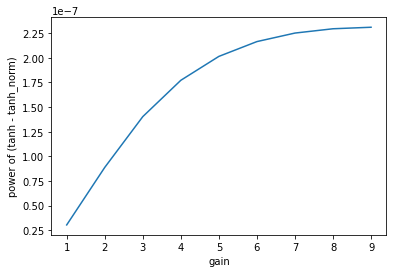

In [63]:
x = []
y = []
for g in np.arange(1, 10, 1):
    tanh = tanh_alt(orig, gain=g)
    tanh_norm = tanh_alt(orig_norm, gain=g)
    delta = array_subtract(tanh, tanh_norm)
    x.append(g)
    y.append(audio_power(delta, fs=fs))
plt.plot(x, y)
plt.xlabel('gain')
plt.ylabel('power of (tanh - tanh_norm)')

Hm, normalize input has almost no effect on the audio power of the saturated signal. Let's look at some numbers: 

In [76]:
gain = 1
tanh = tanh_alt(orig, gain=gain)
tanh_norm = tanh_alt(orig_norm, gain=gain)
print(tanh)
print(tanh_norm)
delta = array_subtract(tanh, tanh_norm)
print(delta.max(), delta.min())

[-0.00115967 -0.00127369 -0.00124591 ... -0.00882872 -0.01029758
 -0.00528684]
[-0.00203818 -0.00223857 -0.00218976 ... -0.01551613 -0.01809725
 -0.00929173]
0.24447639550223355 -0.2469903836989229


Well, -0.25/0.25 looks like it could be some signal. Plot the mel spec

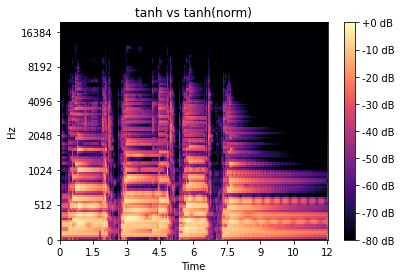

In [125]:
plot_melspec(plt.gca(), delta, 'tanh vs tanh(norm)', bar=True)

In [78]:
stream = open_pyaudio()
stream.write(tanh.astype(np.float32).tobytes())
stream.write(tanh_norm.astype(np.float32).tobytes())
stream.write(delta.astype(np.float32).tobytes())
stream.close()

Ok, normalizing the input array definitely affects the saturated result. But perhaps a better way to compare the two is to subtract the input signal from the saturated signal, and compares those (just compare the 'wet'):

In [79]:
gain = 1
tanh = tanh_alt(orig, gain=gain)
tanh_wet = array_subtract(tanh, orig)
tanh_norm = tanh_alt(orig_norm, gain=gain)
tanh_norm_wet = array_subtract(tanh_norm, orig_norm)
print(tanh)
print(tanh_norm)
delta = array_subtract(tanh, tanh_norm)
print(delta.max(), delta.min())

[-0.00115967 -0.00127369 -0.00124591 ... -0.00882872 -0.01029758
 -0.00528684]
[-0.00203818 -0.00223857 -0.00218976 ... -0.01551613 -0.01809725
 -0.00929173]
0.24447639550223355 -0.2469903836989229


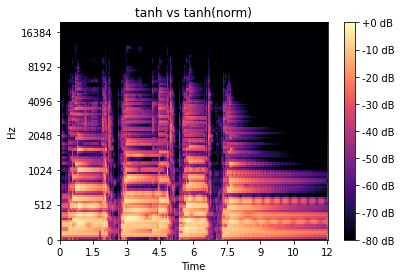

In [124]:
plot_melspec(plt.gca(), delta, 'tanh vs tanh(norm)', bar=True)
stream = open_pyaudio()
stream.write(delta.astype(np.float32).tobytes())
stream.close()

Yeah, even the 'wet' comparison has a significant result, which is a very roundabout way of confirming the suspicion that the relative range of the input array matters, depsite the audio metrics not really show so.

Still, normalizing the input to -1/1 is just another way of applying gain, which is already a parameter of the saturation functions. It might actually be more interesting to use input data that isn't the full -1/1 range, to see the affect of small gains. For now, let's normalize the input data to a fixed number for predictability, say 0.25 so gain=4 is equivalent to -1/1 normalized, and gains >4 go beyond.

In [85]:
orig_25 = 0.25 * orig / np.max(np.abs(orig),axis=0)

## Makeup gain
Investigate how much makeup gain is required for input=1 to give output=1

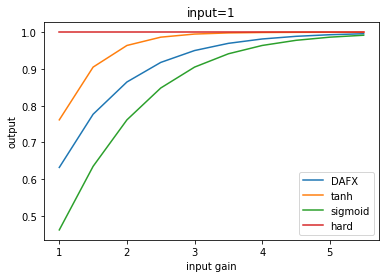

In [86]:
g = np.arange(1, 6, 0.5)
plt.plot(g, dafx(1, gain=g), label='DAFX')
plt.plot(g, tanh_alt(1, gain=g), label='tanh')
plt.plot(g, sigmoid_bipolar(1, gain=g), label='sigmoid')
plt.plot(g, hard_clipping(1, gain=g), label='hard')
plt.xlabel('input gain')
plt.ylabel('output')
plt.title('input=1')
plt.legend()

There is some signal loss with all transfer functions, except the hard clipping, and it varies with the input gain applied. We should be able to normalize the output by calculating the the max output (from input signal=1) and then divide the distorted output by this factor.

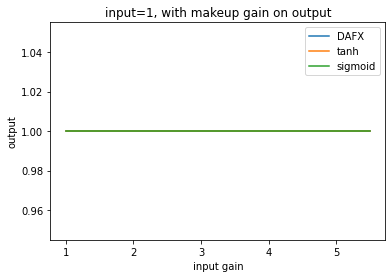

In [87]:
plt.plot(g, dafx(1, gain=g, makeup=True), label='DAFX')
plt.plot(g, tanh_alt(1, gain=g, makeup=True), label='tanh')
plt.plot(g, sigmoid_bipolar(1, gain=g, makeup=True), label='sigmoid')
plt.xlabel('input gain')
plt.ylabel('output')
plt.title('input=1, with makeup gain on output')
plt.legend()

### Makeup gain effect

In [159]:
gain = 4

tanh = tanh_alt(orig_25, gain=gain, makeup=False)
tanh_wet = array_subtract(orig_25, tanh)
tanh_mu = tanh_alt(orig_25, gain=gain, makeup=True)
tanh_mu_wet = array_subtract(orig_25, tanh_mu)
delta = array_subtract(tanh, tanh_mu)
delta_wet = array_subtract(tanh_wet, tanh_mu_wet)
stream = open_pyaudio()
#stream.write(delta.astype(np.float32).tobytes())
stream.close()
seg = seg_from_nparray(delta, fs=fs)
print(seg.dBFS, seg.max_dBFS)
#play(seg)

-5.953349161685281 -3.934106143509051


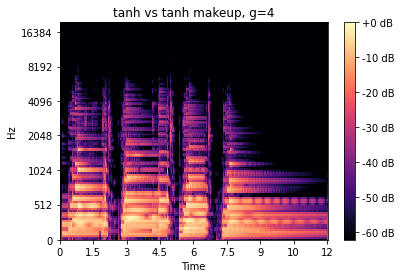

In [160]:
plot_melspec(plt.gca(), delta, 'tanh vs tanh makeup, g={}'.format(gain), bar=True)

The delta between tanh with and without makeup gain is most pronounced at lower gains, and disappears at gain ~= 7.5.